In [1]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

In [70]:
import numpy as np

import keras

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from keras.applications.imagenet_utils import preprocess_input

resnet_model = ResNet50(weights='imagenet', include_top=False, pooling="avg")
# resnet_model.summary()

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x)
    return np.expand_dims(features.flatten(), axis=0)

from os import listdir
features = []
for f in listdir('data/val2014/'):
    features.append(extract_features("data/val2014/" + f))
features = np.array(features)

In [23]:
def load(captions_filename, features_filename):
    features = np.load(features_filename)
    images = []
    texts = []
    with open(captions_filename) as fp:
        for line in fp:
            tokens = line.strip().split()
            images.append(tokens[0])
            texts.append(' '.join(tokens[1:]))
    return features, images, texts

In [74]:
import json
with open('data/annotations/captions_val2014.json', 'r') as f:
    data = json.load(f)

texts = [caption['caption'] for caption in data['annotations']]

# texts = load('data/annotations/captions_val2014.json', "data/val2014/COCO_val2014_000000193405.jpg")

In [60]:
texts[0]

'A bicycle replica with a clock as the front wheel.'

In [75]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)

# It’s the right time to save the vocabulary so that we can reload it later.
vocab = tokenizer.word_index
vocab['<eos>'] = 0

# add word with id 0
import json
with open('vocab.json', 'w') as fp:
    # save the vocab
    fp.write(json.dumps(vocab))

In [76]:
import embedding

embedding_weights = embedding.load(vocab, 100, 'embeddings/glove.twitter.27B.100d.filtered.txt')

loading embeddings from "embeddings/glove.twitter.27B.100d.filtered.txt"


In [95]:
image_input = keras.layers.Input(shape=(2048,))
caption_input = keras.layers.Input(shape=(16,))
noise_input = keras.layers.Input(shape=(16,))

caption_embedding = keras.layers.Embedding(len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = keras.layers.GRU(256)
image_dense = keras.layers.Dense(256, activation='tanh')

image_pipeline = image_dense(image_input)
caption_pipeline = caption_rnn(caption_embedding(caption_input))
noise_pipeline = caption_rnn(caption_embedding(noise_input))

positive_pair = keras.layers.dot([image_pipeline, caption_pipeline], axes=-1)
negative_pair = keras.layers.dot([image_pipeline, noise_pipeline], axes=-1)
output = keras.layers.concatenate([positive_pair, negative_pair])

training_model = keras.models.Model(input=[image_input, caption_input, noise_input], output=output)
image_model = keras.models.Model(input=image_input, output=image_pipeline)
caption_model = keras.models.Model(input=caption_input, output=caption_pipeline)

training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           (None, 16)           0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 16, 100)      1768000     input_48[0][0]                   
                                                                 input_49[0][0]                   
__________

In [45]:
from keras import backend as K

def custom_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.sum(K.maximum(0., 1. - positive + negative))

def accuracy(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.mean(positive > negative)

In [96]:
training_model.compile(loss=custom_loss, optimizer='adadelta', metrics=[accuracy])

In [97]:
noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:9000], captions[:9000], noise[:9000]]
Y_train = fake_labels[:9000]
X_valid = [features[-1000:], captions[-1000:], noise[-1000:]]
Y_valid = fake_labels[-1000:]

shuffle_callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epochs, logs: np.random.shuffle(noise))
nb_epoch = 10

h = training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], nb_epoch=nb_epoch, batch_size=64, callbacks=[shuffle_callback])

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 15s 2ms/step - loss: 52.8909 - accuracy: 0.7338 - val_loss: 98.0032 - val_accuracy: 0.4860
Epoch 2/10
9000/9000 [==============================] - 6s 650us/step - loss: 33.8154 - accuracy: 0.7939 - val_loss: 93.1281 - val_accuracy: 0.3920
Epoch 3/10
9000/9000 [==============================] - 6s 657us/step - loss: 28.3224 - accuracy: 0.8224 - val_loss: 72.3140 - val_accuracy: 0.5090
Epoch 4/10
9000/9000 [==============================] - 6s 661us/step - loss: 26.9101 - accuracy: 0.8287 - val_loss: 85.5962 - val_accuracy: 0.4420
Epoch 5/10
9000/9000 [==============================] - 6s 661us/step - loss: 24.8830 - accuracy: 0.8422 - val_loss: 84.8162 - val_accuracy: 0.4300
Epoch 6/10
9000/9000 [==============================] - 6s 648us/step - loss: 24.5390 - accuracy: 0.8441 - val_loss: 80.2382 - val_accuracy: 0.4850
Epoch 7/10
9000/9000 [==============================] - 6s 672us/

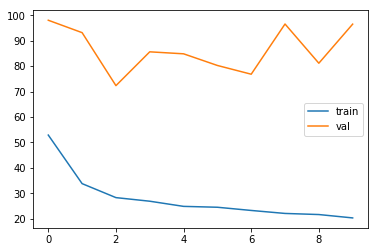

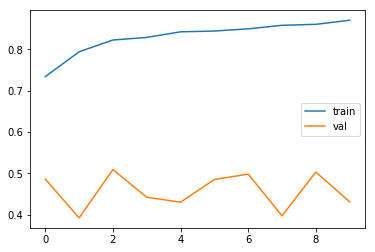

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plt = np.arange(nb_epoch)
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.plot(x_plt, h.history['accuracy'], label='train')
plt.plot(x_plt, h.history['val_accuracy'], label='val')
plt.legend()
plt.show()